## Feature selection methods - Part 1

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz

import eli5
from eli5.sklearn import PermutationImportance

### Simply preprocess data

In [2]:
train = pd.read_csv(r'C:\WORK\Kaggle\house_price\train.csv', header = 0)
test = pd.read_csv(r'C:\WORK\Kaggle\house_price\test.csv', header = 0)

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
nulls = train.isnull().sum().sort_values(ascending = False)
nulls = nulls[nulls > 0]

to_drop = nulls[:5].index.tolist()
train.drop(to_drop, axis = 1, inplace = True)
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500


In [4]:
nulls = train.isnull().sum().sort_values(ascending = False)
nulls = nulls[nulls > 0]
nulls

LotFrontage     259
GarageFinish     81
GarageType       81
GarageCond       81
GarageQual       81
GarageYrBlt      81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrType        8
MasVnrArea        8
Electrical        1
dtype: int64

In [5]:
obj_cols = train.select_dtypes('object').columns
train.drop(obj_cols, axis = 1, inplace = True)
train.drop(['Id'], axis =1, inplace = True)

In [8]:
train.fillna(train.mean(), inplace = True)

In [16]:
X = train.drop(['SalePrice'], axis = 1)
y = train['SalePrice']

rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [35]:
print(X.shape)
print(y.shape)

(1460, 36)
(1460,)


### 1. Filter's methods

#### (1) Feature importance

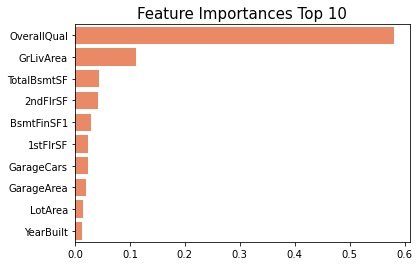

In [60]:
feat_imp = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = False)
top10 = feat_imp[:10]

plt.figure(figsize = (6,4))
sns.barplot(x = top10.values, y = top10.index, color = 'coral')
plt.title('Feature Importances Top 10', fontsize = 15)
plt.show()

#### (2) Variance Threshold

In [42]:
# Variance Threshold
selector = VarianceThreshold(0.8)
train_thresh = selector.fit(train)


del_vars = train.columns[train_thresh.get_support() == False].tolist()
print('#### 삭제된 변수들 ####')
print(del_vars)

#### 삭제된 변수들 ####
['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars']


#### (3) Correlation coefficient

<AxesSubplot:>

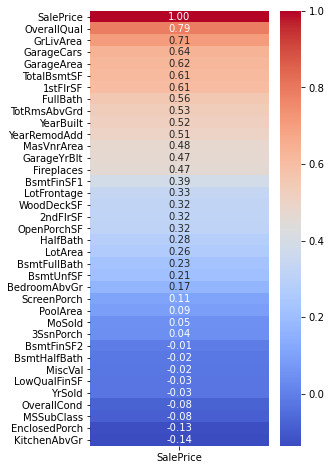

In [53]:
corr_mat = train.corr()[['SalePrice']].sort_values(ascending = False, by = 'SalePrice')

plt.figure(figsize = (4,8))
sns.heatmap(corr_mat, annot = True, fmt = '.2f', cmap = 'coolwarm')

### 2. Wrapper's Methods

#### (1) Recursive Feature Elimination(RFE)

In [57]:
rfe = RFE(rf, n_features_to_select = 20)
train_rfe = rfe.fit(X, y)

del_vars = X.columns[train_rfe.get_support() == False].tolist()
print('#### 삭제된 변수들 ####')
print(del_vars)

#### 삭제된 변수들 ####
['MSSubClass', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']


In [61]:
# RFECV - cross validation 으로 number of selected features 수 결정
selector = RFECV(rf, step = 1, cv = 3)
selector.fit(X, y)

print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True]
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 6 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 4 1 3 7 1 1]


In [63]:
selected_vars = X.columns[selector.support_].tolist()
print('#### 선택된 변수들 ####')
print(selected_vars)
print('Number of variable selected: ', len(selected_vars))

#### 선택된 변수들 ####
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold']
Number of variable selected:  30
